In [1]:
import matplotlib.pyplot as plt
import os, os.path
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate,integrate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
#import pal5_util_old as pal5_util
import gd1_util
#import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from gd1_util_MWhaloshape import lb_to_phi12
from galpy.actionAngle import estimateBIsochrone, actionAngleIsochroneApprox
from gd1_util_MWhaloshape import phi12_to_lb
from scipy.interpolate import UnivariateSpline
from galpy.actionAngle.actionAngleIsochroneApprox import dePeriod



Populating the interactive namespace from numpy and matplotlib


In [2]:
#Jeremy and Jo's model, end of the leading arm
#NOTE: phi1 for this point gives -92 deg, this is a point along the orbit and not a point on the stream
ra=122.968652691887
dec=-9.969068202814725
d = 9.468134830338986
pmra= -1.0277792637560275
pmdec= -7.485334923475567
vlos = 303.54730262016966

lb=bovy_coords.radec_to_lb(np.radians(ra),np.radians(dec))
phi12=lb_to_phi12(lb[0],lb[1])

print (np.degrees(phi12[0])-360.,np.degrees(phi12[1]))

end_coord=[ra,dec,d,pmra,pmdec,vlos]

-92.10954738227082 -3.527698085246242


### determine the time at which the progenitor was at phi1 = -40 deg to get the phase space of the progenitor

In [3]:
tend=np.linspace(-0.031,-0.0316,20)  # these times were obtained by trial and error
diff=np.empty(len(tend))
for ii in range(len(tend)):
    obs= Orbit(end_coord,radec=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])
    ts=np.linspace(0.,tend[ii],500)/bovy_conversion.time_in_Gyr(220.,8.)
    obs.integrate(ts,MWPotential2014)

    ra1=obs.ra(ts[-1])
    dec1=obs.dec(ts[-1])

    lb=bovy_coords.radec_to_lb(np.radians(ra1),np.radians(dec1))
    phi1=np.degrees(lb_to_phi12(lb[0],lb[1])[0])
    if phi1 > 180. : 
        phi1-=360.
    diff[ii]=np.abs(phi1-(-40.))
    
tpro=tend[argmin(diff)]
    
print (tpro)

-0.03153684210526316


### Integrate end coord to the progenitor's location

In [4]:
obs= Orbit(end_coord,radec=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])
ts=np.linspace(0.,tpro,1000)/bovy_conversion.time_in_Gyr(220.,8.)
obs.integrate(ts,MWPotential2014)

ll=obs.ll(ts[-1])
bb=obs.bb(ts[-1])
dist=obs.dist(ts[-1])
pmll=obs.pmll(ts[-1])
pmbb=obs.pmbb(ts[-1])
vlos=obs.vlos(ts[-1])

gd1_prog_lb=[ll,bb,dist,pmll,pmbb,vlos]
print (gd1_prog_lb)

[188.04928416766532, 51.848594007807456, 7.559027173643999, 12.260258757214746, -5.140630283489461, 7.162732847549563]


In [ ]:
print (obs.pmdec(ts[-1]))

### Find isochrone parameter

In [ ]:
prog_orb=Orbit(gd1_prog_lb,lb=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])
orb_galpy=prog_orb._orb.vxvv

ts1=np.linspace(0.,-3.4,1000)/bovy_conversion.time_in_Gyr(220.,8.)
prog_orb.integrate(ts1,MWPotential2014)

print (estimateBIsochrone(MWPotential2014,prog_orb.R(ts1)/8.,prog_orb.z(ts1))/8.)

In [ ]:
#Try different b following the above estimate and visually select based on linearity and quickness of convergence 

aAIA= actionAngleIsochroneApprox(pot=MWPotential2014,b=0.45)
aAIA(*orb_galpy)

aAIA.plot(*orb_galpy,type='araz')

aAIA.plot(*orb_galpy,type='jr')

aAIA.plot(*orb_galpy,type='araz',deperiod=True)

### Make smooth stream
#### We set the stream age = 3.4 Gyr following Jeremy & Jo's paper because that's based on a more accurate stripping rate.
#### We will adjust the length of the mock stream based on the observed stream length by modifying the length factor. 

In [31]:
import gd1_util

#from above b=0.45 looks good
Tstream=4.2 #in Gyr
b=0.45
_sigv=0.3


sdf_leading=gd1_util.setup_gd1model(age=Tstream,new_orb_lb=gd1_prog_lb,isob=b,sigv=_sigv)
sdf_trailing=gd1_util.setup_gd1model(leading=False,age=Tstream,new_orb_lb=gd1_prog_lb,isob=b,sigv=_sigv)

-89.83304838881617 9.974822792561923


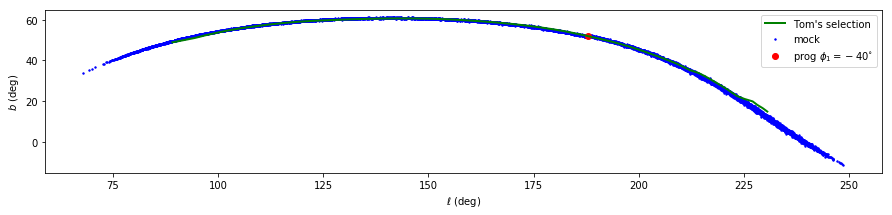

230.90520136585687 98.14391430023633


In [32]:
#plot the Price-Whelan and Bonaca's GD-1 stream selection in l-b coordinates

GD1_obs=np.loadtxt('APW_AB_GD1_phi12.dat')
gd1_lb=phi12_to_lb(GD1_obs[:,0],GD1_obs[:,1],degree=True)

print (min(GD1_obs[:,0]),max(GD1_obs[:,0]))

#sample points from the stream
lb_sample_trailing= sdf_trailing.sample(n=5000,lb=True)
lb_sample_leading= sdf_leading.sample(n=5000,lb=True)

#use Tom's track, but limit to phi1 < 20 deg
tom_dat=np.genfromtxt('fromDenis/GD1_stream_track_density_uncorr.dat',names=True)
tom_p1=tom_dat['phi1mid'][tom_dat['phi1mid'] < 20.]
tom_p2=tom_dat['phi2'][tom_dat['phi1mid'] < 20.]
tom_gd1_lb=phi12_to_lb(tom_p1,tom_p2,degree=True)

plt.figure(figsize=(15,3))

plt.scatter(lb_sample_trailing[0],lb_sample_trailing[1],s=2,c='b',label='mock')
plt.scatter(lb_sample_leading[0],lb_sample_leading[1],s=2,c='b')
#plt.scatter(gd1_lb[:,0],gd1_lb[:,1],label='APW-AB selection')
plt.scatter(gd1_prog_lb[0],gd1_prog_lb[1],c='r',label=r'prog $\phi_{1} = -40^{\circ}$')
plt.plot(tom_gd1_lb[:,0],tom_gd1_lb[:,1],c='g',lw=2,label='Tom\'s selection' )
plt.xlabel(r'$\ell$ (deg)')
plt.ylabel(r'$b$ (deg)')
#plt.ylim(13,65)
plt.legend(loc='upper right')
plt.show()

print (max(gd1_lb[:,0]),min(gd1_lb[:,0]))




In [ ]:
#plot angle vs longitude

plt.figure()
plt.plot(sdf_leading._interpolatedObsTrackLB[:,0],sdf_leading._interpolatedThetasTrack,label='leading')

plt.plot(sdf_trailing._interpolatedObsTrackLB[:,0],sdf_trailing._interpolatedThetasTrack,label='trailing')
plt.legend(loc='upper center')
plt.show()



In [26]:
# function that takes in l and outputs the corresponding parallel angle

def l_to_angle(sdf,l):
    
    if sdf._interpolatedObsTrackLB[:,0][1] > sdf._interpolatedObsTrackLB[:,0][0] : #ad-hoc way to check whether increasing
        interp=interpolate.interp1d(sdf._interpolatedObsTrackLB[:,0],sdf._interpolatedThetasTrack,kind='cubic')
        
    else :
        interp=interpolate.interp1d(sdf._interpolatedObsTrackLB[:,0][::-1],sdf._interpolatedThetasTrack[::-1],kind='cubic')
        
    return (interp(l))


In [27]:
def compute_angular_length(sdf,ll):
    
    #for a given stream arm, computes the length along the stream track 
    # takes in the longitude of the far end and convert to angle
    aa=l_to_angle(sdf,ll)
    
    #copied from Jo's code
    # Need to now integrate length
    if numpy.median(numpy.roll(sdf._interpolatedObsTrackLB[:,0],-1)
                    -sdf._interpolatedObsTrackLB[:,0]) > 0.:
        ll= dePeriod(sdf._interpolatedObsTrackLB[:,0][:,numpy.newaxis].T*numpy.pi/180.).T*180./numpy.pi
    else:
        ll= dePeriod(sdf._interpolatedObsTrackLB[::-1,0][:,numpy.newaxis].T*numpy.pi/180.).T[::-1]*180./numpy.pi
    if numpy.median(numpy.roll(sdf._interpolatedObsTrackLB[:,1],-1)
                    -sdf._interpolatedObsTrackLB[:,1]) > 0.:
        bb= dePeriod(sdf._interpolatedObsTrackLB[:,1][:,numpy.newaxis].T*numpy.pi/180.).T*180./numpy.pi
    else:
        bb= dePeriod(sdf._interpolatedObsTrackLB[::-1,1][:,numpy.newaxis].T*numpy.pi/180.).T[::-1]*180./numpy.pi
    dlda= interpolate.InterpolatedUnivariateSpline(\
        sdf._interpolatedThetasTrack,ll,k=3).derivative()
    dbda= interpolate.InterpolatedUnivariateSpline(\
        sdf._interpolatedThetasTrack,bb,k=3).derivative()
    result= integrate.quad(lambda da: numpy.sqrt(dlda(da)**2.\
                                                     +dbda(da)**2.),
                           0.,aa)[0]
    
    return result


    

### Compare stream length to observed stream length


In [33]:
#Determine length factors

#compute the length of the stream upto the point where the density drops below 20% 
mock_trail_length = sdf_trailing.length(ang=True)
mock_lead_length = sdf_leading.length(ang=True)

obs_lead_length = compute_angular_length(sdf_leading,max(gd1_lb[:,0]))
obs_trail_length = compute_angular_length(sdf_trailing,min(gd1_lb[:,0]))

obs_tom_lead_length = compute_angular_length(sdf_leading,max(tom_gd1_lb[:,0]))
obs_tom_trail_length = compute_angular_length(sdf_trailing,min(tom_gd1_lb[:,0]))

trail_length_fac = obs_trail_length/mock_trail_length
lead_length_fac =  obs_lead_length/mock_lead_length

print (mock_trail_length,obs_tom_trail_length, obs_trail_length)
print (mock_lead_length, obs_tom_lead_length, obs_lead_length)

print (trail_length_fac, lead_length_fac)

print (obs_tom_trail_length/mock_trail_length, obs_tom_lead_length/mock_lead_length)

#print (obs_tom_lead_length,obs_tom_trail_length)

113.12755560305142 102.00056545263082 92.09236122327428
78.31001541046066 59.296301757451005 59.84477663645315
0.8140577309600265 0.7642033566559492
0.9016420880738939 0.7571994648021765


Observed trailing arm length in deg =  92.09400406579196
Observed leading arm length in deg =  59.83346223561357
mock length =  179.41006033808048
observed length =  151.92746630140553


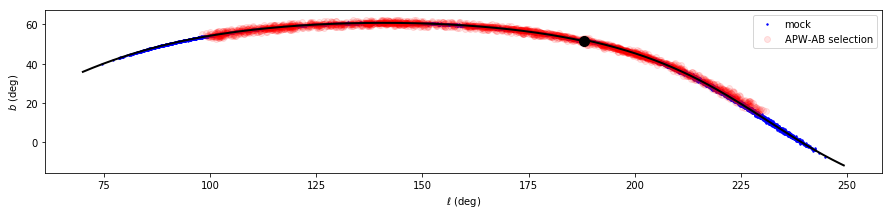

In [23]:
#observed stream length
print ("Observed trailing arm length in deg = ", + compute_angular_length(sdf_trailing,min(gd1_lb[:,0])))
print ("Observed leading arm length in deg = ", + compute_angular_length(sdf_leading,max(gd1_lb[:,0])))

print ("mock length = ",mock_trail_length+mock_lead_length)
print ("observed length = ",compute_angular_length(sdf_trailing,min(gd1_lb[:,0])) + compute_angular_length(sdf_leading,max(gd1_lb[:,0])) )
#compute the length along the stream track between the extremities of the observed stream
##interpolate track
tracklb_trailing=np.radians(sdf_trailing._interpolatedObsTrackLB[:,0]),np.radians(sdf_trailing._interpolatedObsTrackLB[:,1])
tracklb_leading=np.radians(sdf_leading._interpolatedObsTrackLB[:,0]),np.radians(sdf_leading._interpolatedObsTrackLB[:,1])
#int_dbdl_trail=UnivariateSpline(np.degrees(tracklb_trailing[0][::-1]), np.degrees(tracklb_trailing[1])[::-1]).derivative()
#int_dbdl_lead=UnivariateSpline(np.degrees(tracklb_leading[0]), np.degrees(tracklb_leading[1])).derivative()
#def d_arc_trail(l):
#    return np.sqrt(1. + int_dbdl_trail(l)**2)

#def d_arc_lead(l):
#    return np.sqrt(1. + int_dbdl_lead(l)**2)

#trail_length = integrate.quad(d_arc_trail,min(gd1_lb[:,0]),gd1_prog_lb[0])[0]

#lead_length = integrate.quad(d_arc_lead,gd1_prog_lb[0],max(gd1_lb[:,0]))[0]
#print ("observed stream track length",lead_length + trail_length)

plt.figure(figsize=(15,3))

plt.scatter(lb_sample_trailing[0],lb_sample_trailing[1],s=2,c='b',label='mock')
plt.scatter(lb_sample_leading[0],lb_sample_leading[1],s=2,c='b')

plt.scatter(gd1_lb[:,0],gd1_lb[:,1],c='r',alpha=0.1,label='APW-AB selection')
plt.scatter(gd1_prog_lb[0],gd1_prog_lb[1],c='k',s=100)

plt.plot(np.degrees(tracklb_trailing[0]),np.degrees(tracklb_trailing[1]),lw=2,c='k')
plt.plot(np.degrees(tracklb_leading[0]),np.degrees(tracklb_leading[1]),lw=2,c='k')

plt.xlabel(r'$\ell$ (deg)')
plt.ylabel(r'$b$ (deg)')
#plt.ylim(1,65)
#plt.xlim(-100.,20.)
#plt.ylim(-6.,4.)
plt.legend(loc='upper right')
plt.show()

In [ ]:
import numpy
import matplotlib.pyplot as plt

apar=numpy.arange(0.,1.75,0.01)

dens_lead= [sdf_leading._density_par(a) for a in apar]
dens_trail= [sdf_trailing._density_par(a) for a in apar]

plt.figure(figsize=(7,5))
plt.plot(apar,dens_lead,c='r')
plt.plot(apar,dens_trail,c='k')
plt.show()

In [ ]:
plt.figure(figsize=(15,3))
plt.scatter(GD1_obs[:,0],GD1_obs[:,1])
plt.show()

## Compare stream width

### Take both arms, bin in fine $\phi_{1}$ bins. For each bin, compute std dev of $\phi_{2}$ of the sample, combine all these std dev via the weighted average of their variances. This is because the mean $\phi_{2}$ is changing in each bin, although by very little. 

In [34]:
#convert lb --> phi1, phi2
phi12_sample_trailing=lb_to_phi12(lb_sample_trailing[0],lb_sample_trailing[1],degree=True)
phi12_sample_leading=lb_to_phi12(lb_sample_leading[0],lb_sample_leading[1],degree=True)

for ii in range(len(phi12_sample_trailing)):
    if phi12_sample_trailing[:,0][ii]>180.:
        phi12_sample_trailing[:,0][ii]-=360.
        
    if phi12_sample_leading[:,0][ii]>180.:
        phi12_sample_leading[:,0][ii]-=360.

In [ ]:
print (phi12_sample_leading)

In [35]:
bin_width=2.
phi1_trail_min=-40 #-40.
phi1_trail_max=-10.#  to compare with Koposov's work max(GD1_obs[:,0])#-10.

phi1_lead_min=-60. # to compare with Koposov's work  #min(GD1_obs[:,0])
phi1_lead_max=-40.

nbin_trail=int(-(-phi1_trail_max+phi1_trail_min)//bin_width) +1
nbin_lead=int(-(-phi1_lead_max+phi1_lead_min)//bin_width) +1

#print (nbin_trail, nbin_lead)

phi1_bin_trail_edges=np.linspace(phi1_trail_min,phi1_trail_max,nbin_trail)
phi1_bin_lead_edges=np.linspace(phi1_lead_min,phi1_lead_max,nbin_lead)

#print (phi1_bin_lead_edges)

phi2_offset=[]
phi2_std=[]
npop=[]


for ii in range(nbin_trail-1):
#    #phi2_mean = np.mean(phi12_sample_trailing[:,1][(phi1_bin_trail_edges[ii] < phi12_sample_trailing[:,0]) & ( phi12_sample_trailing[:,0] < phi1_bin_trail_edges[ii+1])])
    p2 = phi12_sample_trailing[:,1][(phi1_bin_trail_edges[ii] < phi12_sample_trailing[:,0]) & ( phi12_sample_trailing[:,0] < phi1_bin_trail_edges[ii+1])]
    phi2_mean=np.mean(p2)
    phi2_std.append(np.std(p2))
    npop.append(len(p2))
    p2-=phi2_mean
    for p in p2 :
        phi2_offset.append(p)
        
for ii in range(nbin_lead-1):
    #phi2_mean = np.mean(phi12_lead[:,1][(phi1_bin_lead_edges[ii] < phi12_lead[:,0]) & ( phi12_lead[:,0] < phi1_bin_lead_edges[ii+1])])
    p2 = phi12_sample_leading[:,1][(phi1_bin_lead_edges[ii] < phi12_sample_leading[:,0]) & ( phi12_sample_leading[:,0] < phi1_bin_lead_edges[ii+1])]
    phi2_mean=np.mean(p2)
    phi2_std.append(np.std(p2))
    npop.append(len(p2))
    p2-=phi2_mean
    for p in p2 :
        phi2_offset.append(p)



var_mean=np.sum((np.array(npop)-1)*(np.array(phi2_std)**2.))/(np.sum(np.array(npop))-len(npop))

sig_width=np.sqrt(var_mean)*60.
print ("Angular width %.2f arcmins"%(sig_width))

Angular width 11.09 arcmins


In [ ]:
from scipy.stats import norm

phi2=np.linspace(-0.8,0.8,50)

plt.figure()
plt.hist(phi2_offset,bins='scott',density=True)
plt.plot(phi2,norm.pdf(phi2,scale=sig_width/60.),label=r'Normal dist') #normal distribution with sigma = 14 arcmin
plt.vlines(7./60,0.,2.,color='r')
plt.vlines(-7./60,0.,2.,color='r')
plt.xlabel(r'$\phi_{2} - \langle\phi_{2}\rangle $')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#overplot GD1 stars selected by APW and AB
GD1_obs=np.loadtxt('APW_AB_GD1_phi12.dat')

plt.figure(figsize=(15,3))
#plt.plot(phi12_trail[:,0],phi12_trail[:,1],lw=2,c='gray')
#plt.plot(phi12_lead[:,0],phi12_lead[:,1],lw=2,c='gray')

#plt.plot(phi12_trail[:,0],phi12_trail[:,1]+(7./60.),ls='--',lw=2,c='r')
#plt.plot(phi12_trail[:,0],phi12_trail[:,1]-(7./60.),ls='--',lw=2,c='r')
#plt.plot(phi12_lead[:,0],phi12_lead[:,1]+(7./60.),ls='--',lw=2,c='r')
#plt.plot(phi12_lead[:,0],phi12_lead[:,1]-(7./60.),ls='--',lw=2,c='r')

plt.scatter(phi12_sample_trailing[:,0],phi12_sample_trailing[:,1],s=2,c='b',label='mock sample')
plt.scatter(phi12_sample_leading[:,0],phi12_sample_leading[:,1],s=2,c='b')

plt.scatter(GD1_obs[:,0],GD1_obs[:,1],c='r',s=3,label='APW-AB-selection')
plt.vlines(-38.,-4,2.5)
plt.vlines(-42.,-4,2.5)

#plt.vlines(-22.,-4,2.5)
plt.vlines(max(GD1_obs[:,0]),-4,2.5)

plt.vlines(min(GD1_obs[:,0]),-4,2.5)
#plt.vlines(-18.,-4,2.5)



plt.xlabel(r'$\phi_{1}$ (deg)')
plt.ylabel(r'$\phi_{2}$ (deg)')
#plt.xlim(-100.,20.)
#plt.ylim(-6.,4.)
plt.legend(loc='upper right')
plt.show()

In [ ]:

#phi12_trail=np.degrees(lb_to_phi12(tracklb_trailing[0],tracklb_trailing[1]))
#phi12_lead=np.degrees(lb_to_phi12(tracklb_leading[0],tracklb_leading[1]))

#print (np.degrees(phi12[0])-360.,np.degrees(phi12[1]))
#for ii in range(len(phi12_trail)):
#    if phi12_trail[:,0][ii]>180.:
#        phi12_trail[:,0][ii]-=360.
        
#for ii in range(len(phi12_lead)):
#    if phi12_lead[:,0][ii]>180.:
#        phi12_lead[:,0][ii]-=360.

#print (phi12_lead)
                        

### determine the time at which the progenitor was at phi1 = -20 deg to get the phase space of the progenitor

In [ ]:
tend=np.linspace(-0.053,-0.056,20)  # these times were obtained by trial and error
diff=np.empty(len(tend))
for ii in range(len(tend)):
    obs= Orbit(end_coord,radec=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])
    ts=np.linspace(0.,tend[ii],500)/bovy_conversion.time_in_Gyr(220.,8.)
    obs.integrate(ts,MWPotential2014)

    ra1=obs.ra(ts[-1])
    dec1=obs.dec(ts[-1])

    lb=bovy_coords.radec_to_lb(np.radians(ra1),np.radians(dec1))
    phi1=np.degrees(lb_to_phi12(lb[0],lb[1])[0])
    
    if phi1 > 180. : 
        phi1-=360.
        
    #print (phi1)
    diff[ii]=np.abs(phi1-(-0.))
#print (min(diff))    
tpro=tend[argmin(diff)]
    
print (tpro)

### Integrate end coord to the progenitor's location

In [ ]:
obs= Orbit(end_coord,radec=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])
ts=np.linspace(0.,tpro,1000)/bovy_conversion.time_in_Gyr(220.,8.)
obs.integrate(ts,MWPotential2014)

ll=obs.ll(ts[-1])
bb=obs.bb(ts[-1])
dist=obs.dist(ts[-1])
pmll=obs.pmll(ts[-1])
pmbb=obs.pmbb(ts[-1])
vlos=obs.vlos(ts[-1])

gd1_prog_lb=[ll,bb,dist,pmll,pmbb,vlos]
print (gd1_prog_lb)

### Find isochrone parameter

In [ ]:
prog_orb=Orbit(gd1_prog_lb,lb=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])
orb_galpy=prog_orb._orb.vxvv

ts1=np.linspace(0.,-3.4,1000)/bovy_conversion.time_in_Gyr(220.,8.)
prog_orb.integrate(ts1,MWPotential2014)

print (estimateBIsochrone(MWPotential2014,prog_orb.R(ts1)/8.,prog_orb.z(ts1))/8.)


In [ ]:
#Try different b following the above estimate and visually select based on linearity and quickness of convergence 

aAIA= actionAngleIsochroneApprox(pot=MWPotential2014,b=0.45)
aAIA(*orb_galpy)

aAIA.plot(*orb_galpy,type='araz')

aAIA.plot(*orb_galpy,type='jr')

aAIA.plot(*orb_galpy,type='araz',deperiod=True)

### Make smooth stream

In [ ]:
import gd1_util

#from above b=0.4 looks good
Tstream=3.4
sdf_leading=gd1_util.setup_gd1model(age=Tstream,new_orb_lb=gd1_prog_lb,isob=0.45,sigv=0.36)
#sdf_trailing=gd1_util.setup_gd1model(leading=False,age=Tstream,new_orb_lb=gd1_prog_lb,isob=0.45,sigv=0.36)

### Compare stream length to observed stream length

In [ ]:
#sample points from the stream
#lb_sample_trailing= sdf_trailing.sample(n=3000,lb=True)
lb_sample_leading= sdf_leading.sample(n=3000,lb=True)


#compute the length of the stream upto the point where the density drops below 20%
print ("mock stream length in lb coord",sdf_leading.length(ang=True) + sdf_trailing.length(ang=True))


#compute the length along the stream track between the extremities of the observed stream
#tracklb_trailing=np.radians(sdf_trailing._interpolatedObsTrackLB[:,0]),np.radians(sdf_trailing._interpolatedObsTrackLB[:,1])
tracklb_leading=np.radians(sdf_leading._interpolatedObsTrackLB[:,0]),np.radians(sdf_leading._interpolatedObsTrackLB[:,1])

GD1_obs=np.loadtxt('APW_AB_GD1_phi12.dat')
gd1_lb=phi12_to_lb(GD1_obs[:,0],GD1_obs[:,1],degree=True)

#int_dbdl_trail=UnivariateSpline(np.degrees(tracklb_trailing[0][::-1]), np.degrees(tracklb_trailing[1])[::-1]).derivative()
int_dbdl_lead=UnivariateSpline(np.degrees(tracklb_leading[0]), np.degrees(tracklb_leading[1])).derivative()


def d_arc_trail(l):
    return np.sqrt(1. + int_dbdl_trail(l)**2)

def d_arc_lead(l):
    return np.sqrt(1. + int_dbdl_lead(l)**2)

#trail_length = integrate.quad(d_arc_trail,min(gd1_lb[:,0]),max(np.degrees(tracklb_trailing[0])))[0]

lead_length = integrate.quad(d_arc_lead,min(np.degrees(tracklb_leading[0])),max(gd1_lb[:,0]))[0]

print ("observed stream track length",lead_length + trail_length)

plt.figure(figsize=(15,3))

#plt.scatter(lb_sample_trailing[0],lb_sample_trailing[1],s=2,c='b')
plt.scatter(lb_sample_leading[0],lb_sample_leading[1],s=2,c='b')

plt.scatter(gd1_lb[:,0],gd1_lb[:,1],c='r',alpha=0.1)

#plt.plot(np.degrees(tracklb_trailing[0]),np.degrees(tracklb_trailing[1]),lw=2,c='k')
plt.plot(np.degrees(tracklb_leading[0]),np.degrees(tracklb_leading[1]),lw=2,c='k')

plt.xlabel(r'$\ell$ (deg)')
plt.ylabel(r'$b$ (deg)')
#plt.xlim(-100.,20.)
#plt.ylim(-6.,4.)
#plt.legend(loc='upper right')
plt.show()

In [ ]:
import numpy
import matplotlib.pyplot as plt

apar=numpy.arange(0.,1.75,0.01)

dens_lead= [sdf_leading._density_par(a) for a in apar]
dens_trail= [sdf_trailing._density_par(a) for a in apar]

plt.figure(figsize=(7,5))
plt.plot(apar,dens_lead,c='r')
plt.plot(apar,dens_trail,c='k')
plt.show()

## Compare stream width

### Take both arms excluding 4 degrees around the progenitor at -20 deg. Bin in $1^{\circ} \phi_{1}$ bins. For each bin, compute mean $\phi_{2}$ of the track, subtract this mean from the $\phi_{2}$ of all the points in that bin.  Compute the std deviation of all these offset corrected $\phi_{2}$

In [ ]:
phi12_sample_trailing=lb_to_phi12(lb_sample_trailing[0],lb_sample_trailing[1],degree=True)
phi12_sample_leading=lb_to_phi12(lb_sample_leading[0],lb_sample_leading[1],degree=True)

for ii in range(len(phi12_sample_trailing)):
    if phi12_sample_trailing[:,0][ii]>180.:
        phi12_sample_trailing[:,0][ii]-=360.
        
    if phi12_sample_leading[:,0][ii]>180.:
        phi12_sample_leading[:,0][ii]-=360.



phi12_trail=np.degrees(lb_to_phi12(tracklb_trailing[0],tracklb_trailing[1]))
phi12_lead=np.degrees(lb_to_phi12(tracklb_leading[0],tracklb_leading[1]))

#print (np.degrees(phi12[0])-360.,np.degrees(phi12[1]))
for ii in range(len(phi12_trail)):
    if phi12_trail[:,0][ii]>180.:
        phi12_trail[:,0][ii]-=360.
        
for ii in range(len(phi12_lead)):
    if phi12_lead[:,0][ii]>180.:
        phi12_lead[:,0][ii]-=360.

print (phi12_lead)
                          

In [ ]:
bin_width=1.
phi1_trail_min=2.
phi1_trail_max=10.

phi1_lead_min=-80.
phi1_lead_max=-2.

nbin_trail=int(-(-phi1_trail_max+phi1_trail_min)//bin_width) +1
nbin_lead=int(-(-phi1_lead_max+phi1_lead_min)//bin_width) +1

#print (nbin_trail, nbin_lead)

phi1_bin_trail_edges=np.linspace(phi1_trail_min,phi1_trail_max,nbin_trail)
phi1_bin_lead_edges=np.linspace(phi1_lead_min,phi1_lead_max,nbin_lead)

#print (phi1_bin_edges)

phi2_offset=[]
phi2_std=[]


for ii in range(nbin_trail-1):
    #phi2_mean = np.mean(phi12_sample_trailing[:,1][(phi1_bin_trail_edges[ii] < phi12_sample_trailing[:,0]) & ( phi12_sample_trailing[:,0] < phi1_bin_trail_edges[ii+1])])
    p2 = phi12_sample_trailing[:,1][(phi1_bin_trail_edges[ii] < phi12_sample_trailing[:,0]) & ( phi12_sample_trailing[:,0] < phi1_bin_trail_edges[ii+1])]
    phi2_mean=np.mean(p2)
    phi2_std.append(np.std(p2)*60.)
    p2-=phi2_mean
    for p in p2 :
        phi2_offset.append(p)
        
for ii in range(nbin_lead-1):
    #phi2_mean = np.mean(phi12_lead[:,1][(phi1_bin_lead_edges[ii] < phi12_lead[:,0]) & ( phi12_lead[:,0] < phi1_bin_lead_edges[ii+1])])
    p2 = phi12_sample_leading[:,1][(phi1_bin_lead_edges[ii] < phi12_sample_leading[:,0]) & ( phi12_sample_leading[:,0] < phi1_bin_lead_edges[ii+1])]
    phi2_mean=np.mean(p2)
    phi2_std.append(np.std(p2)*60.)
    p2-=phi2_mean
    for p in p2 :
        phi2_offset.append(p)



In [ ]:
from scipy.stats import norm

phi2=np.linspace(-0.8,0.8,50)


print ("Angular width %.2f arcmins"%(np.std(phi2_offset)*60.))


plt.figure()
plt.hist(phi2_offset,bins='scott',density=True)
plt.plot(phi2,norm.pdf(phi2,scale=14./60.),label=r'Normal dist') #normal distribution with sigma = 14 arcmin
plt.vlines(7./60,0.,2.,color='r')
plt.vlines(-7./60,0.,2.,color='r')
plt.xlabel(r'$\phi_{2} - \langle\phi_{2}\rangle $')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#overplot GD1 stars selected by APW and AB
GD1_obs=np.loadtxt('APW_AB_GD1_phi12.dat')

plt.figure(figsize=(15,3))
plt.plot(phi12_trail[:,0],phi12_trail[:,1],lw=2,c='gray')
plt.plot(phi12_lead[:,0],phi12_lead[:,1],lw=2,c='gray')

plt.plot(phi12_trail[:,0],phi12_trail[:,1]+(7./60.),ls='--',lw=2,c='r')
plt.plot(phi12_trail[:,0],phi12_trail[:,1]-(7./60.),ls='--',lw=2,c='r')
plt.plot(phi12_lead[:,0],phi12_lead[:,1]+(7./60.),ls='--',lw=2,c='r')
plt.plot(phi12_lead[:,0],phi12_lead[:,1]-(7./60.),ls='--',lw=2,c='r')

plt.scatter(phi12_sample_trailing[:,0],phi12_sample_trailing[:,1],s=2,c='b')
plt.scatter(phi12_sample_leading[:,0],phi12_sample_leading[:,1],s=2,c='b')

#plt.scatter(GD1_obs[:,0],GD1_obs[:,1],c='k',s=2,label='APW-AB-selection')
#plt.vlines(-38.,-4,2.5)
#plt.vlines(-42.,-4,2.5)

plt.vlines(-22.,-4,2.5)
plt.vlines(10.,-4,2.5)

plt.vlines(-90.,-4,2.5)
plt.vlines(-18.,-4,2.5)



plt.xlabel(r'$\phi_{1}$ (deg)')
plt.ylabel(r'$\phi_{2}$ (deg)')
#plt.xlim(-100.,20.)
#plt.ylim(-6.,4.)
#plt.legend(loc='upper right')
plt.show()

In [ ]:
prog_orb=Orbit(gd1_prog_lb,lb=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])

ts1=np.linspace(0.,-2.3,1000)/bovy_conversion.time_in_Gyr(220.,8.)
prog_orb.integrate(ts1,MWPotential2014)

prog_orb.plot(d1='x',d2='y')
prog_orb.plot(d1='R',d2='z')

print (prog_orb.rperi(),prog_orb.rap(),prog_orb.e(),prog_orb.Tr(use_physical=True))

print (prog_orb.r(ts1))



### For 2.3 Gyr age of the stream, consider ~ 1 Myr time for interaction with the GMCs, so 2300 samplings --> 36 chunks of size 64. 

In [ ]:
def convert_dens_to_obs(apars,phi1_input,dens,dens_smooth,mO,poly_deg=3,poly_norm=True):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    #outll= numpy.arange(-60.,-5.,0.1) ##NOTE: phi1 = -10
    outll=phi1_input
    phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
    phi1[phi1 > 180.]-=360.
    #print phi1
    phi1=phi1[::-1]
    # Interpolate density
    pp= Polynomial.fit(apars,dens,deg=3)
    ipll= interpolate.InterpolatedUnivariateSpline(phi1,apars[::-1])
    #ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/pp(apars))
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))

In [ ]:
def parse_times(times,age,ro=8.,vo=220.):
    if 'sampling' in times:
        nsam= int(times.split('sampling')[0])
        print (nsam)
        return [float(ti)/bovy_conversion.time_in_Gyr(vo,ro)
                for ti in numpy.arange(1,nsam+1)/(nsam+1.)*age]
    return [float(ti)/bovy_conversion.time_in_Gyr(vo,ro)
            for ti in times.split(',')]
            
timpacts= parse_times('64sampling',9.,ro=8.,vo=220.)

#print (np.array(timpacts)*bovy_conversion.time_in_Gyr(220.,8.))


In [ ]:
orb_lb=[188.04928416766532, 51.848594007807456, 7.559027173643999, 12.260258757214746, -5.140630283489461, 7.162732847549563]
#isob=0.4

sdf=gd1_util.setup_gd1model(timpact=timpacts,hernquist=True,new_orb_lb=orb_lb,isob=0.4,age=3.4)

In [ ]:
with open('gd1pepper_leading_Hernquist_td3.4_64sampling_progphi1-40.0_MW2014.pkl','rb') as savefile:
            sdf_pepper_lead= pickle.load(savefile,encoding='latin1')

        
with open('gd1pepper_trailing_Hernquist_td3.4_64sampling_progphi1-40.0_MW2014.pkl','rb') as savefile:
            sdf_pepper_trail= pickle.load(savefile,encoding='latin1')


In [ ]:
with open('pkl_files/gd1_smooth_pepper_trailing_Plummer_sigv0.27_streamwidth10arcmins_td3.4_64sampling_progphi1-40.0_MW2014.pkl','rb') as savefile:
            sdf_trailing= pickle.load(savefile,encoding='latin1')
            sdf_pepper_trail= pickle.load(savefile,encoding='latin1')
            
with open('pkl_files/gd1_smooth_pepper_leading_Plummer_sigv0.27_streamwidth10arcmins_td3.4_64sampling_progphi1-40.0_MW2014.pkl','rb') as savefile:
            sdf_leading= pickle.load(savefile,encoding='latin1')
            sdf_pepper_lead= pickle.load(savefile,encoding='latin1')

print (sdf_pepper_trail._length_factor,sdf_pepper_lead._length_factor)

timpact1=sdf_pepper_trail._timpact
timpact=sdf_pepper_lead._timpact

In [ ]:
print (timpact)

In [ ]:
            
ro=8.
vo=220.

#time in reverse
    
#print (timpact1[kk])
x=[]
y=[]
z=[]

x1=[]
y1=[]
z1=[]

xyz_trail= sdf_pepper_trail._sgapdfs_coordtransform[timpact1[0]]._kick_interpolatedObsTrackXY
apar_trail=sdf_pepper_trail._sgapdfs_coordtransform[timpact1[0]]._kick_interpolatedThetasTrack

xyz_lead= sdf_pepper_lead._sgapdfs_coordtransform[timpact[0]]._kick_interpolatedObsTrackXY
apar_lead=sdf_pepper_lead._sgapdfs_coordtransform[timpact[0]]._kick_interpolatedThetasTrack

print (min(apar_trail),max(apar_trail))
print (min(apar_lead),max(apar_lead))
           
        
apar_max1=sdf_pepper_trail.length(tdisrupt=sdf_pepper_trail._tdisrupt-timpact1[0])*sdf_pepper_trail._length_factor
apar_max=sdf_pepper_lead.length(tdisrupt=sdf_pepper_lead._tdisrupt-timpact[0])*sdf_pepper_lead._length_factor
    
#considering the stream until apar_max, store xyzvxvyvz 
for ii in range(len(apar_trail)):
    if apar_trail[ii] <= apar_max1 : 
        x1.append(xyz_trail[:,0][ii])
        y1.append(xyz_trail[:,1][ii])
        z1.append(xyz_trail[:,2][ii])


for ii in range(len(apar_lead)):
    if apar_lead[ii] <= apar_max : 
        x.append(xyz_lead[:,0][ii])
        y.append(xyz_lead[:,1][ii])
        z.append(xyz_lead[:,2][ii])
    
lbd_lead=bovy_coords.XYZ_to_lbd(np.array(x),np.array(y),np.array(z),degree=True)
lbd_trail=bovy_coords.XYZ_to_lbd(np.array(x1),np.array(y1),np.array(z1),degree=True)

plt.figure()
plt.plot(lbd_lead[0],lbd_lead[1])
#plt.xlim(-20.,20.)
#plt.ylim(-17.,17.)
plt.show()

In [ ]:
plt.figure()
plt.plot(lbd_lead[:,0],lbd_lead[:,1])
#plt.xlim(-20.,20.)
#plt.ylim(-17.,17.)
plt.show()

In [ ]:
for ii in range(0,10,2) :
    print (ii)

In [ ]:
print (0.365/2.*(9./1.5))

In [ ]:
GD1_obs=np.loadtxt('APW_AB_GD1_phi12.dat')
print (min(GD1_obs[:,0]),max(GD1_obs[:,0]))



In [ ]:
#angular dispersion in the transverse direction  

w_trail= sdf_trailing.sigangledAngle(sdf_trailing._meandO*sdf_trailing._tdisrupt,simple=True,
                               use_physical=False)

w_lead= sdf_leading.sigangledAngle(sdf_leading._meandO*sdf_leading._tdisrupt,simple=True,
                               use_physical=False)

print (np.degrees(w_lead)*60.,np.degrees(w_trail)*60.)


print (sdf_trailing._determine_stream_spreadLB